In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

import pmdarima as pm
from pmdarima.pipeline import Pipeline


plt.rcParams['figure.figsize'] = (16, 4)

In [2]:
#!pip install pmdarima

In [3]:
#data = pd.read_csv("data/data_v1.csv")
data = pd.read_csv("data/data_v2.csv")

In [4]:
data.head()

,time,price,exog
0,2015-01-01 00:00:00,64.92,5856.0
1,2015-01-01 01:00:00,64.48,5454.0
2,2015-01-01 02:00:00,59.32,5151.0
3,2015-01-01 03:00:00,56.04,4861.0
4,2015-01-01 04:00:00,53.63,4617.0


In [5]:
data.time = pd.to_datetime(data.time, infer_datetime_format=True)

data = data.set_index('time',    # <---- Set the index to be our timestamp data  
                      drop=True)      # <---- drop the original column

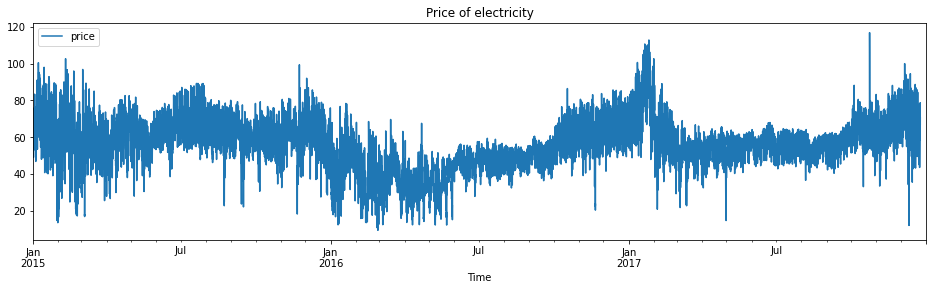

In [6]:
data[["price"]].plot()
plt.xlabel('Time')
plt.title('Price of electricity')
plt.show()

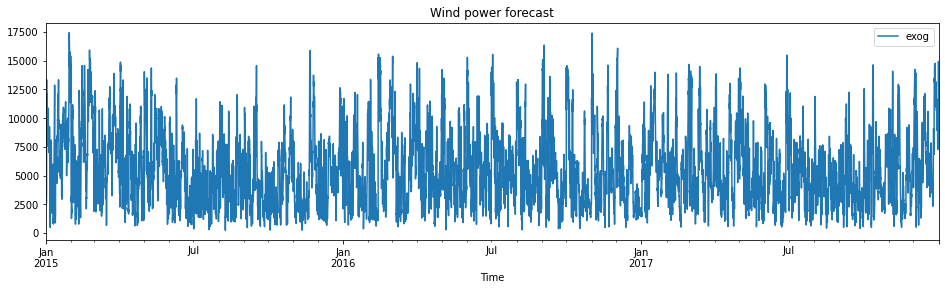

In [7]:
data[["exog"]].plot()
plt.xlabel('Time')
plt.title('Wind power forecast')
plt.show()

In [8]:
#check data for nan
data.isnull().sum()

price    168
exog       0
dtype: int64

In [9]:
#check that there are no missing hours
data = data.resample('H').asfreq()
data.isnull().sum()

price    168
exog       0
dtype: int64

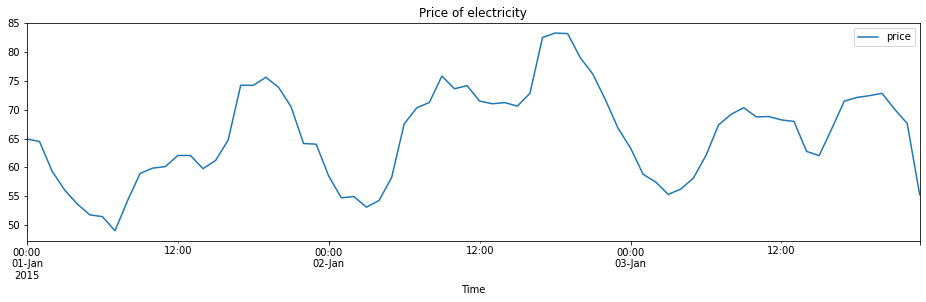

In [10]:
#check for seasonality
#plot three days
data[["price"]][0:72].plot()
plt.xlabel('Time')
plt.title('Price of electricity')
plt.show()

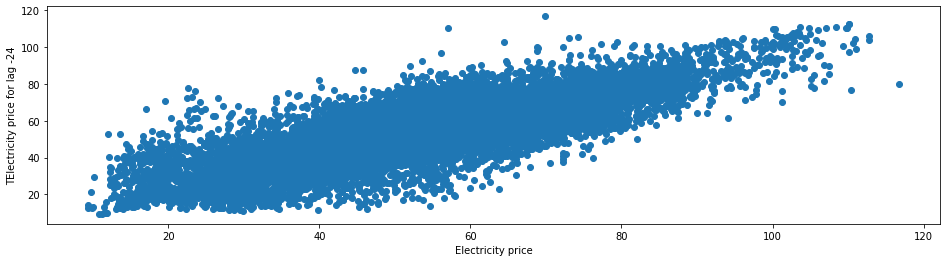

In [11]:
#check lag of 24 hours
#data = data.to_frame()
data['lag_24'] = data['price'].shift(-24)

plt.scatter(data['price'], data.lag_24)
plt.ylabel('TElectricity price for lag -24')
plt.xlabel('Electricity price')
plt.show()

In [12]:
#check for correlations
data.corr()['price']

price     1.000000
exog     -0.201387
lag_24    0.825182
Name: price, dtype: float64

In [13]:
data_to_model = data.drop(["lag_24", "exog"], axis=1).dropna()

In [14]:
data_to_model

,price
time,
2015-01-01 00:00:00,64.92
2015-01-01 01:00:00,64.48
2015-01-01 02:00:00,59.32
2015-01-01 03:00:00,56.04
2015-01-01 04:00:00,53.63
...,...
2017-12-24 19:00:00,77.99
2017-12-24 20:00:00,78.69
2017-12-24 21:00:00,71.87


In [15]:
#decompose using additive model because variance doesnt vary with time
decomposition = seasonal_decompose(data_to_model, model='additive')


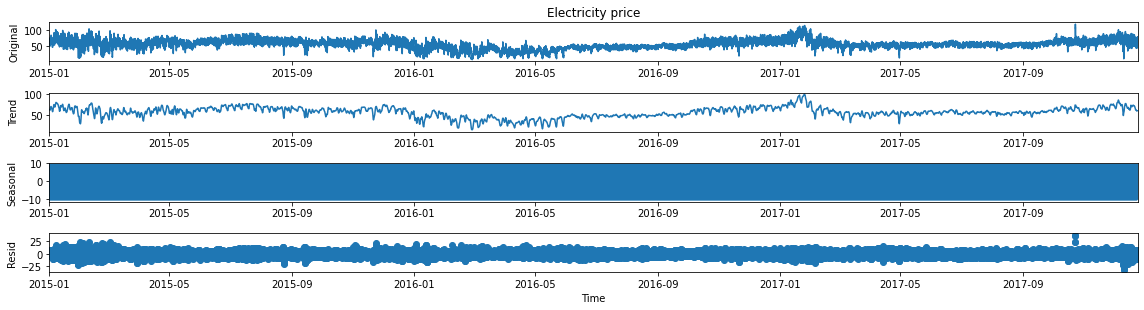

In [16]:
fig = decomposition.plot()
fig.axes[0].set_title('Electricity price')
fig.axes[0].set_ylabel('Original')
fig.axes[3].set_xlabel('Time')
plt.show()

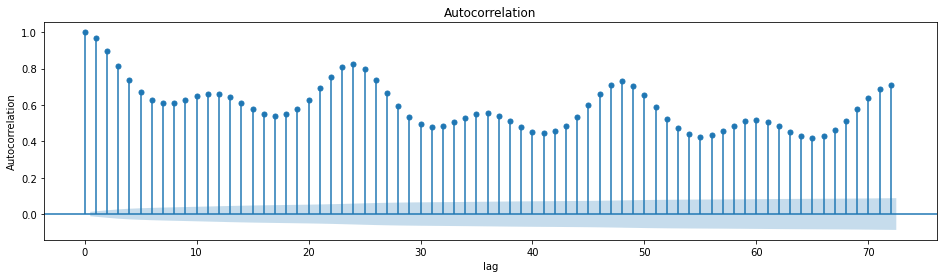

In [17]:
plot_acf(data_to_model, alpha=.05, lags=72)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

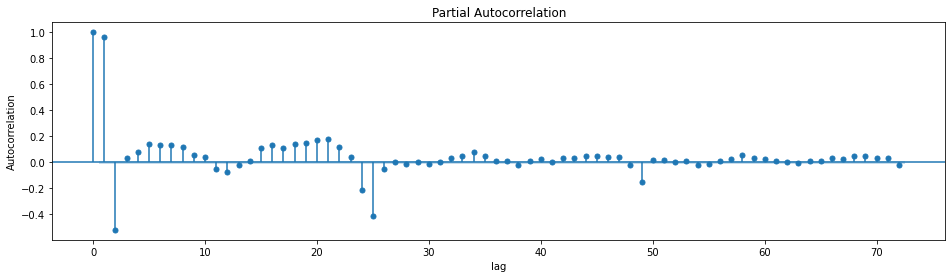

In [18]:
plot_pacf(data_to_model, alpha=0.05, lags=72)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [19]:
#check if data is stationary
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model)
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -8.14
pvalue:    0.000


In [20]:
data_to_model_logged = np.log(data_to_model)
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model_logged)
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -8.84
pvalue:    0.000


In [21]:
data_to_model_logged_diff = data_to_model_logged.diff()
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model_logged_diff.dropna())
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -29.61
pvalue:    0.000


In [22]:
len(data_to_model)*0.2

5227.200000000001

In [23]:
train = data_to_model_logged[:-134]
test = data_to_model_logged[-134:]

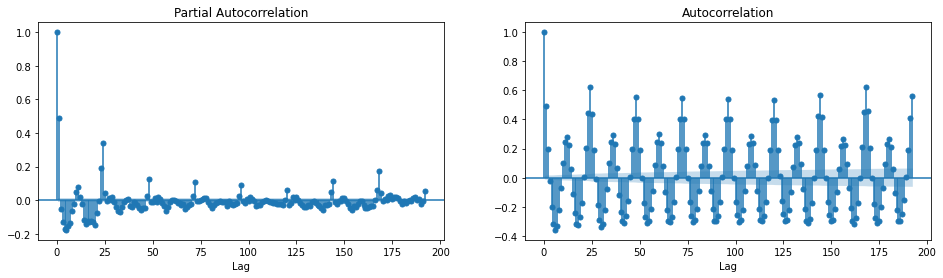

In [24]:
fig, ax = plt.subplots(1,2)
plot_pacf(train.diff().dropna(), alpha=.05, lags=24*8, ax=ax[0], method='ols') 
plot_acf(train.diff().dropna(), alpha=.05, lags=24*8, ax=ax[1])
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag')
plt.show()

In [ ]:
# sets up the SARIMAX model
sarimax_c = SARIMAX(train, trend='c',        
                         order=(2, 1, 1),              # <-- keeping same parameters as before
                         seasonal_order=(2, 0, 2, 12)) # <-- we'll get into how we found these hyper parameters later

# trains the SARIMAX model
sarimax_results = sarimax_c.fit(maxiter=1000)

# predictions
sarimax_predictions = np.exp(sarimax_results.predict())[134:] # grab the prediction from our model and undo the log transform using exp

/home/ana/.virtualenvs/hckt03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ana/.virtualenvs/hckt03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
plt.plot(np.exp(train), label='original')
plt.plot(sarimax_predictions, label='sarimax forecast')
plt.xlabel('Time')
plt.title('# Electricity price')
plt.legend()
plt.show()

In [ ]:
sarimax_forecast = sarimax_results.get_forecast(134)

In [ ]:
plt.plot(data_to_model, label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [ ]:
plt.plot(data_to_model[-500:], label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [ ]:
mean_absolute_error(np.exp(sarimax_forecast.predicted_mean),np.exp(test))

In [ ]:
#finding the best parameters for SARIMAX
sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12)
sarimax.fit(train)

In [ ]:
sarimax_forecast = sarimax.predict(134)
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test))

In [ ]:
plt.plot(data_to_model, label='original')
plt.plot(test.index, np.exp(sarimax_forecast), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [ ]:
print(len(train), len(test))

In [ ]:
#adding exogenus data

exog = data.drop(["price", "lag_24"], axis=1)
exog_train = exog[0:538]
exog_test = exog[538:len(data_to_model)]

In [ ]:
print(len(exog_train), len(exog_test))

In [ ]:
exog_test

In [ ]:
sarimax_pipeline_exog = Pipeline([ 
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(train,exog_train)

In [ ]:
sarimax_pipeline_exog.predict(134,exog_test)

In [ ]:
sarimax_forecast_exog = sarimax_pipeline_exog.predict(134,exog_test)
mean_absolute_error(np.exp(sarimax_forecast_exog),np.exp(test))

In [ ]:
plt.plot(data_to_model, label='original')
plt.plot(test.index, np.exp(sarimax_forecast_exog), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [ ]:
#train_all = data_to_model
data_v2 = pd.read_csv("data/data_v2.csv")
data_v2.time = pd.to_datetime(data_v2.time, infer_datetime_format=True)

data_v2 = data_v2.set_index('time',    # <---- Set the index to be our timestamp data  
                      drop=True)      # <---- drop the original column

In [ ]:
train_all = data_v2.drop(["exog"], axis=1).dropna()

In [ ]:
train_all = np.log(train_all)

In [ ]:
# sets up the SARIMAX model
sarimax_c = SARIMAX(train_all, trend='c',        
                         order=(2, 1, 1),              # <-- keeping same parameters as before
                         seasonal_order=(2, 0, 2, 12)) # <-- we'll get into how we found these hyper parameters later

# trains the SARIMAX model
sarimax_results = sarimax_c.fit(maxiter=1000)



In [ ]:
# predictions
sarimax_forecast_c = sarimax_results.get_forecast(168)
#mean_absolute_error(np.exp(sarimax_forecast_c.predicted_mean),np.exp(test))

In [ ]:
predictions = sarimax_forecast_c.predicted_mean.values
predictions = np.exp(predictions)

In [ ]:
#pd.read_csv("data/sample_submission.csv")

In [ ]:
submission = pd.DataFrame(data=predictions, columns=["price"])
#submission.to_csv("sarimax_no_exogenus_v1")
submission.to_csv("sarimax_no_exogenus_v2")

In [ ]:
submission

In [ ]:
submission